# <span style="color:orange">Quality Data Analysis - Project Work [FULL PROJECT] </span>
## Team 1

### Course Details:
- Academic Year: 2023-2024

### Project Details:
- Title: [ENTER PROJECT TITLE HERE]

### Team Members:
- Abylaikhan Orynbassar
- Giulia Mezzadri
- Federico Angelo Mor
- Federica Rena

### Instructor:
- Panagiotis Tsiamyrtzis

# Instructions
- This is a template notebook for the project work.
- Please fill in the details above (team members, instructor, etc.)
## PHASE 1 - Report structure
Please use the following sections for your project report:
- **Introduction** [max 3500 characters including spaces]
    - Recap the project work framework and objective
    - Briefly summarize the overall methodology you used to model and analyse your data
    - Briefly summarize the state-of-the-art you analysed to support your study (if any).
- **Assumptions and preliminary data analysis** [max 5000 characters including spaces]
    - Clearly state and motivate all the assumptions your proposed methodology relies on; present and discuss any preliminary data analysis and visualization you applied on the data.
- **Proposed methodology** [max 10000 characters including spaces]
    - Synthetically describe, motivate and critically discuss your proposed statistical process monitoring approach. 
- **Results** [max 10000 characters including spaces]
    - Synthetically presents and discuss the results of your statistical process monitoring design. 

## PHASE 2 - Report structure
Please use the following sections for your project report:
- **Preliminary data analysis** [max 5000 characters including spaces]
    - Synthetically describe and discuss any preliminary data analysis and visualization applied on the new dataset.
- **Test of your proposed approach on new data** [max 5000 characters including spaces]
    - Synthetically presents and discuss the results you got applying to the new data your previously designed statistical process monitoring approach.
- **Discussion** [max 5000 characters including spaces]
    - Critically discuss your results In this Section you can also propose possible ways to tune or revise your previously designed method to enhance its defect detection performance. 

You can add code cells to any of the above sections to show your code or display images. Each block of code should be accompanied by a brief description of what it does (not counted in characters limits).

## Submission
- Name your notebook as `teamXX.ipynb` where `XX` is your team number.
- Submit your notebook together with the Dataframe as a ZIP file on Webeep by the deadline. The ZIP file name must clearly state the "TEAM NUMBER".

# PHASE 1 ------------------------------

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Introduction
<!-- i am adding numbers to titles so is tidier i think -->

<!-- - Recap the project work framework and objective
- Briefly summarize the overall methodology you used to model and analyse your data
- Briefly summarize the state-of-the-art you analysed to support your study (if any). -->

The overall procedure can be summarized as follows:
- Dataset creation and refinement [section 2](#Assumptions-and-preliminary-data-analysis)
- Variables definition and selection [section 3](#Proposed-methodology)
- Control charting [section 3](#Proposed-methodology)

where each point will be further detailed in the next sections (as linked trough the square brackets).

# Assumptions and preliminary data analysis
<!-- - Clearly state and motivate all the assumptions your proposed methodology relies on; present and discuss any preliminary data analysis and visualization you applied on the data. -->
About the assumptions, we later check normality, but at the beginning we did not assumed anything special about our data.

Regarding the data analysis, instead, after the image acquisition we ran the provided python script to generate all the images statistics (which we refer as `df_old`). At that stage the unique "key" which identified each object (inside each image) was the combination of the Image Name and Position variables, so we opted to merge them into a single ID using this simple function (of which the inverse function, to recover Image Name and Position given the created ID, could also be easily defined):

```python
def img_info_to_part_id(imgname, location):
	imgid = int(re.search(r"img(\d+)\.bmp", imgname).group(1))
	if location == "top_left":
		return (imgid - 1) * 4
	elif location == "bottom_left":
		return (imgid - 1) * 4 + 1
	elif location == "top_right":
		return (imgid - 1) * 4 + 2
	elif location == "bottom_right":
		return (imgid - 1) * 4 + 3

# img_info_to_part_id("img01.bmp", "top_left")     -> 0
# img_info_to_part_id("img01.bmp", "bottom_left")  -> 1
# img_info_to_part_id("img01.bmp", "top_right")    -> 2
# img_info_to_part_id("img01.bmp", "bottom_right") -> 3
# img_info_to_part_id("img02.bmp", "top_left")     -> 4
# img_info_to_part_id("img02.bmp", "bottom_left")  -> 5
# img_info_to_part_id("img02.bmp", "top_right")    -> 6
# img_info_to_part_id("img02.bmp", "bottom_right") -> 7
```

The provided python script also included a segmentation part which automatically isolated the single objects by cropping a region around them. However, soon after we decided to implement our own code to do the segmentation, since we thought that to compare more fairly the image statistics we needed a "common ground" on which they should be computed. That is, we thought that we should firstly center the objects and crop them around their main outer edge, and only then compute their statistics. 

Otherwise we believed that the values some possibly relevant and orientation/position-dependenent variables, such as the Perimeter or the Axes Lengths, would have been altered by the random disposition of the original objects in the images. In this way instead we brough everything to the same context (perfect centering alignement and perfect cropping), so that the later comparison of their characteristics would be more accurate.

To perform this we wrote the following function

```python
def rotate_and_crop(img, rect):
	# get params
	center, size, angle = rect[0], rect[1], rect[2]
	# angle correction (e.g. so that angle of 80 becomes -10)
	if angle > 45: 
		angle = angle - 90
	# round as int the center and size coordinates
	center, size = tuple(map(int, center)), tuple(map(int, size))
	# get row and col num in img
	height, width = img.shape[0], img.shape[1]
	# rotation matrix
	M = cv2.getRotationMatrix2D(center, angle, 1)
	# apply rotation
	img_rot = cv2.warpAffine(img, M, (width, height))
	# crop it
	img_crop = cv2.getRectSubPix(img_rot, size, center)
	return img_crop, img_rot
```

which we applied in the final procedure of the new dataset definition (we refer to it as `df_new`) which consisted in the following steps:
1. load (and read as grayscale) the original cropped images generated with the python script
2. binarize them using Otsu threshold
3. apply the Canny filter to detect the edges
4. select the largest edge to compute the parameters for rotation and cropping
5. apply rotate and crop function

We can see the results of these operations in the following figure.

<!-- 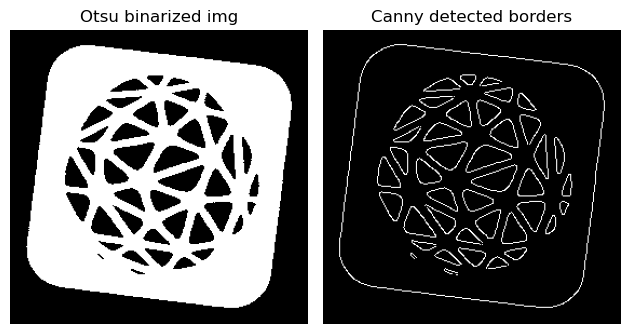 -->
<!-- 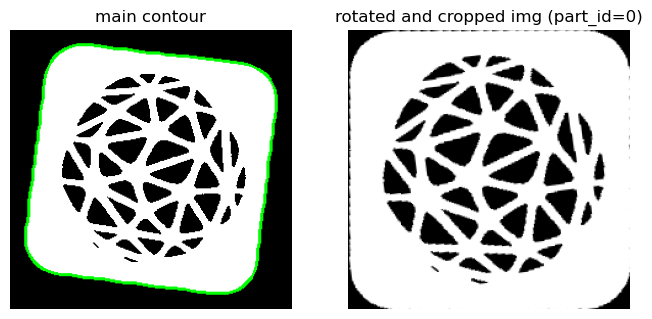 -->
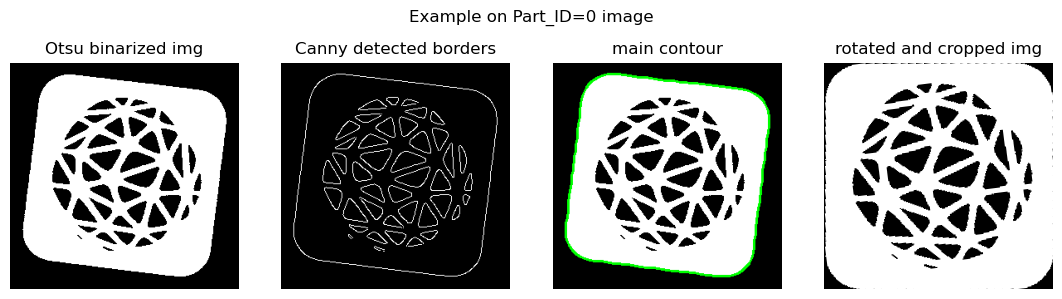

We also noticed that this refinement was useful to make the statistics extraction more effective. Indeed we found several cases in which after the "correction" we got more precise estimates of the number of voids, as if the centering and cropping procedure, which morally induced also a "zooming", evidenced better those voids regions.

For example in the next image we see how we moved from 44 to 42 voids, since in the new labeling we have a single void labeled 16 rather than two in the old case, as well as no region corresponding to label 44 in the old one (which instead was probably just a random white pixel).

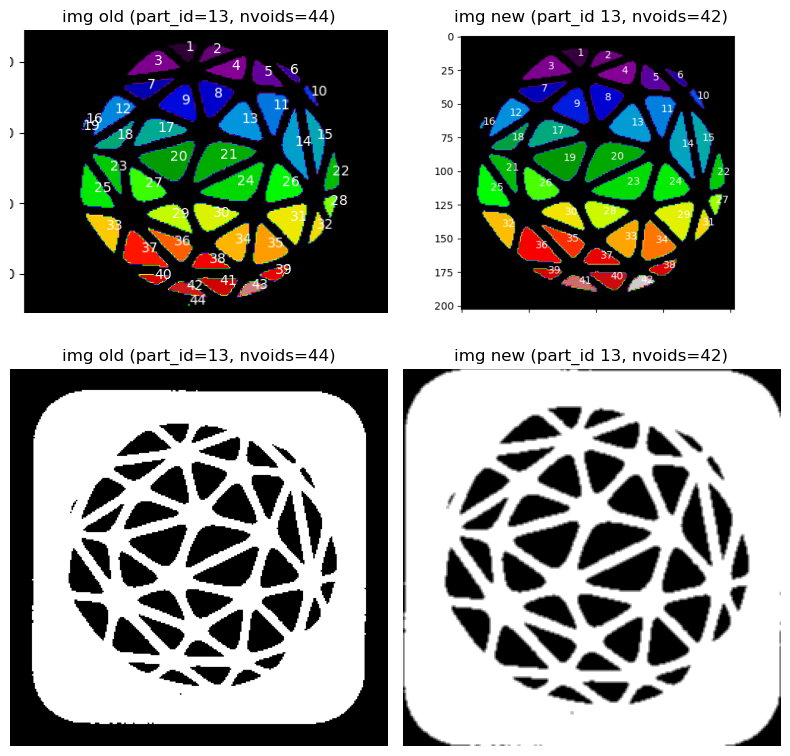

Moreover, we created some new variables to enrich the description of our data, of which here we provide a brief description:
- `Part_ID` (already mentioned) to uniquely determine each object;
- `Num_voids` to count how many voids each object had;
- `Num_Wpixels` and `Num_Bpixels` to count the number of white and black pixels, but being them absolute values dependent on the images size we deemed more proper to study the ratio of pixel counts, as the next variable does;
- `Wpixels_ratio` defined as the number of white pixels over the total number of pixels in the image 
and we separated the new dataset into two parts, one just related to the full parts, the other just to the voids.

Finally we divided the data into _parts_ and _voids_, to separate their information, and so we got these datasets
<!-- This separation was motivated from the idea, about building the control charts, of first studying the variables in the _part_ dataset, and later ... dont know -->

In [11]:
df_new = pd.read_csv('../Processed dataset/df_new.csv')
df_new_parts = pd.read_csv('../Processed dataset/df_new_parts.csv')
df_new_voids = pd.read_csv('../Processed dataset/df_new_voids.csv')

print("df_new shape:", df_new.shape)
print("df_new_parts shape:", df_new_parts.shape)
print("df_new_voids shape:", df_new_voids.shape)

df_new_parts.head()

df_new shape: (1786, 18)
df_new_parts shape: (40, 18)
df_new_voids shape: (1746, 18)


,Image name,Position,Region type,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels],Part_ID,Num_voids,Num_Wpixels,Num_Bpixels,Wpixels_ratio
0,img01.bmp,top_left,part,0,38291,4105.674,0.153,-1.268,0.760,0.743,277.925,274.667,220.802,0,41,38291,13692,0.736606
1,img01.bmp,bottom_left,part,0,37887,4155.306,0.157,-1.304,0.752,0.735,279.026,275.584,219.634,1,42,37887,14096,0.728834
2,img01.bmp,top_right,part,0,37334,4106.076,0.189,1.564,0.752,0.734,277.777,272.791,218.026,2,46,37334,14194,0.724538
3,img01.bmp,bottom_right,part,0,37868,4139.319,0.164,-1.070,0.756,0.738,277.900,274.158,219.579,3,45,37868,13661,0.734887
4,img02.bmp,top_left,part,0,36599,4223.005,0.118,-0.817,0.730,0.713,280.140,278.182,215.869,4,41,36599,15385,0.704044


### Dataset comparison 

The two datasets seemed to provide two different sets of variables with different values. We verified the difference thanks to nonparametric intervals (Boostrap t-intervals) and the respective tests. In this preliminary phase of our analysis, we did not assume normality and so we chose to use a nonparametric approach to compare the different datasets. We study separately the "part" dataset and the "void" one.  
Note: We neglected the Bonferroni correction since for large dataset ( n > 30) the correction is almost negligible.

We tested for each variable i, 
$$ H_0: mean(df\_parts\_i - df\_new\_parts\_i) = 0 \quad \text{vs} \quad H_1: H_0^c $$  
We obtained the following confident intervals:
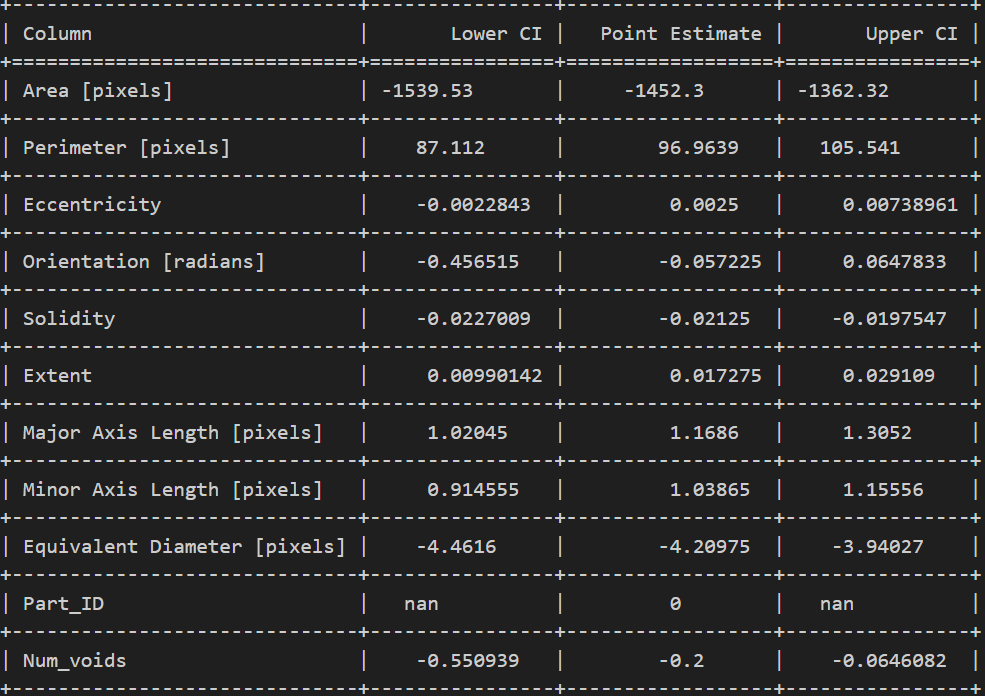

As the majority of intervals do not include zero, we can confidently reject the null hypothesis in most cases with a confidence level of 95%.






The same test was conducted for the "void" datasets, albeit with a variation. In this instance, we considered 40 distinct datasets, each corresponding to a different image in order to compare the different variables related to the same image.

We tested for each variable i related to the image j,
$$ H_0: mean(df\_parts_{ij} - df\_new\_parts_{ij}) = 0 \quad \text{vs} \quad H_1: H_0^c $$  
We obtained the following intervals (for example we show only the ones related to the last image):
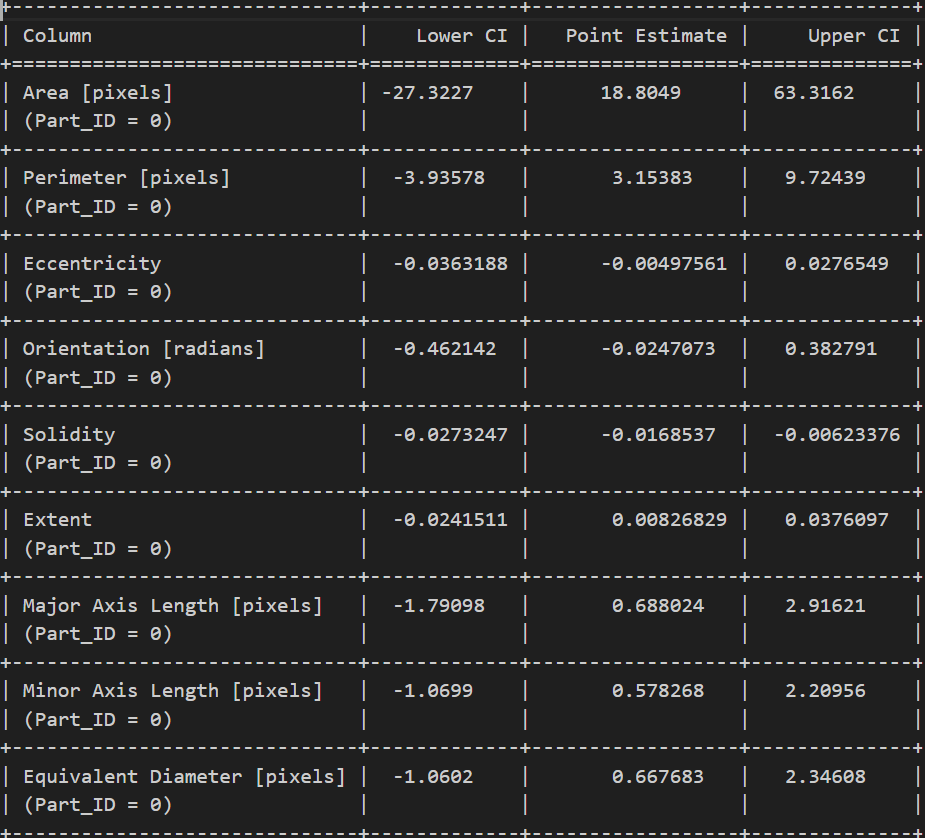

Almost all the intervals seem to include the zero and so we cannot reject the null hypothesis in the majority of the cases.  
But, since we noticed a difference in the previous tests, we decided to analyze the new dataset beacuse it should guarantee a "common ground" on which images should be computed.



# Proposed methodology

# Results

# References (if any)

# PHASE 2 -----------------------------

# Preliminary data analysis

# Test of your proposed approach on new data

# Discussion